# Import all required packages to run this notebook

In [125]:
# Data extraction imports
import os 
import tarfile
import pandas as pd
from six.moves import urllib

# Visualization and organization imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix

#Scikit-Learn imports
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer, Imputer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.externals import joblib

# Background:

- Use California census data and median house pricing by block to build a regression model to predict median house pricing by block (smallest geographical unit for which sample census data is available).

- The dataset is from 1990, so will likely not generalize well to current date

## Data download and import

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    
    if not os.path.isdir(housing_path):
        
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path = HOUSING_PATH):
    
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data(HOUSING_URL,HOUSING_PATH)

In [4]:
housing_data = load_housing_data()

# Exploratory Analysis

## Check datatypes, look for null values, and get summary stats 

In [5]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


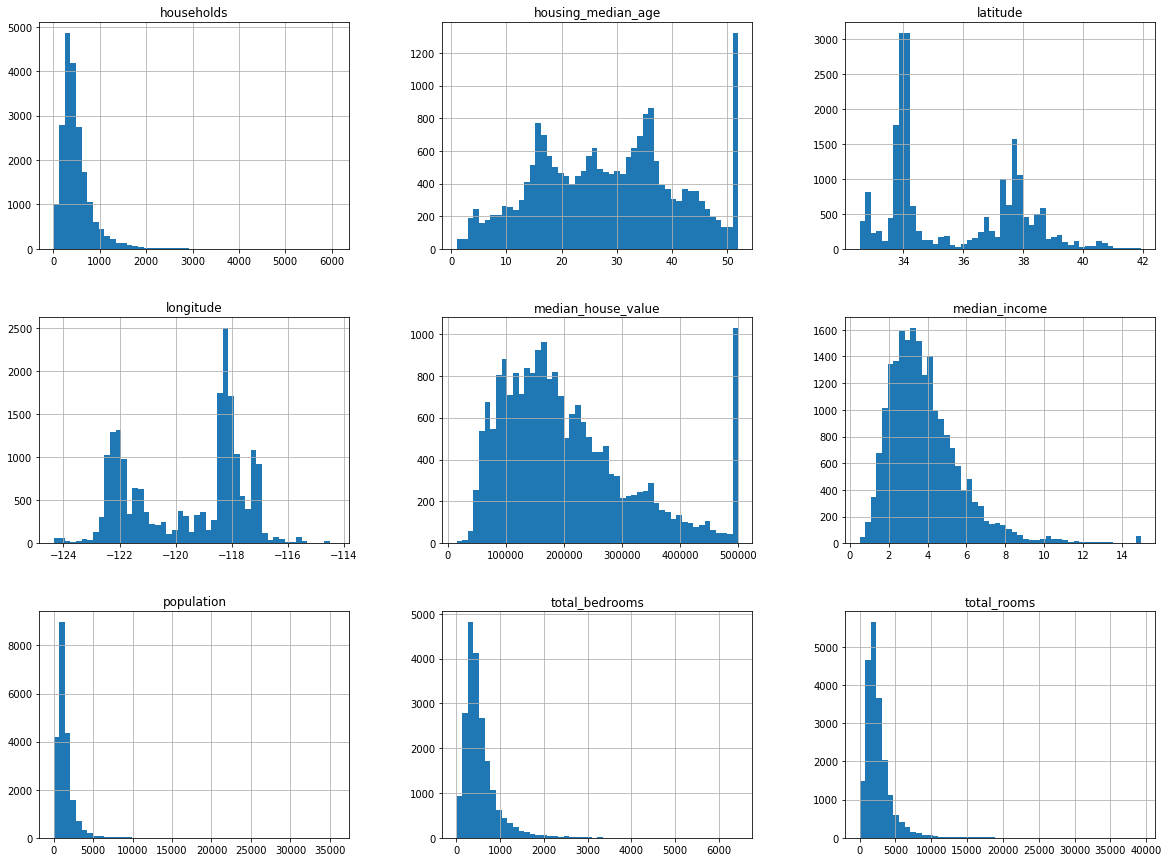

In [9]:
housing_data.hist(bins = 50, figsize = (20,15))
plt.show()

## some notes about the data:
- median income is preprocessed to lie between 0.4999 for low median income and 15.0001 for high median income
- housing median age and median house value are also capped
- these are apparent from the existence of large last bins.
    - depending on the goal, may need to be removed, but we will address that later.
- Some distributions are non-normal we may employ transformations later to try to get normal shaped distributions which might improve ML algorithm performance.

In [10]:
np.log(housing_data['median_house_value'].values)

array([13.02276401, 12.78968394, 12.77167051, ..., 11.43279942,
       11.34687088, 11.40087596])

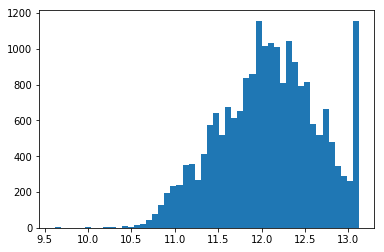

In [11]:
plt.hist(x=np.log(housing_data['median_house_value'].values),bins=50)
plt.show()

## Create test set

- Will be created based on ensuring a representative sample of median income

In [12]:
#Let's one hot encode the ocean proximity label before we split the data
binarizer = LabelBinarizer()
one_hot = binarizer.fit_transform(housing_data['ocean_proximity'].fillna('missing'))
one_hot_df = pd.DataFrame(one_hot,columns=binarizer.classes_)
binarized_housing_data = pd.concat([housing_data,one_hot_df],axis=1,ignore_index=False)
if 'missing' in binarizer.classes_:
    binarized_housing_data = binarized_housing_data.drop(['missing'], axis = 1)

In [13]:
binarized_housing_data.groupby('ocean_proximity').agg('sum')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
ocean_proximity,,,,,,,,,,,,,,
<1H OCEAN,-1085793.19,315745.43,267495.0,24012547.0,4937435.0,13889374.0,4730118.0,38651.5100,2.193410e+09,9136,0,0,0,0
INLAND,-784370.82,240630.21,159005.0,17803933.0,3468095.0,9112744.0,3127759.0,21022.1353,8.176001e+08,0,6551,0,0,0
ISLAND,-591.77,166.79,212.0,7873.0,2102.0,3340.0,1383.0,13.7221,1.902200e+06,0,0,5,0,0
NEAR BAY,-279976.99,86564.42,86402.0,5710320.0,1167195.0,2817427.0,1118931.0,9555.9061,5.935962e+08,0,0,0,2290,0
NEAR OCEAN,-317185.93,92334.77,78005.0,6867477.0,1415482.0,3598955.0,1332308.0,10647.3760,6.629955e+08,0,0,0,0,2658


In [14]:
housing_data = binarized_housing_data.drop(['ocean_proximity'],axis = 1)
#create income categories
housing_data['income_cat'] = np.ceil(housing_data['median_income']/1.5)
housing_data['income_cat'].where(housing_data['income_cat'] < 5, 5.0,inplace = True)

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing_data, housing_data['income_cat']):
    
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [15]:
print(len(strat_train_set), "train +", len(strat_test_set), "test")

16512 train + 4128 test


In [16]:
housing_data['income_cat'].value_counts() / len(housing_data)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [18]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [19]:
for s in (strat_train_set,strat_test_set):
    s.drop(['income_cat'],axis=1,inplace=True)

In [20]:
housing_data = strat_train_set.copy()

## Make some visualizations

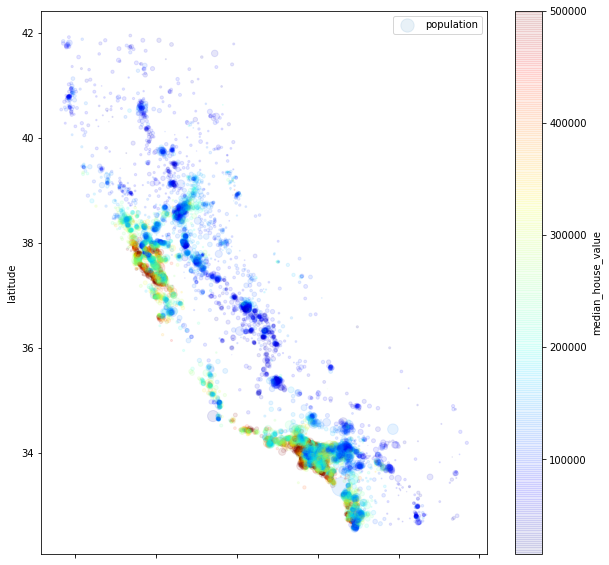

In [21]:
housing_data.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1,
                 s=housing_data['population'] / 100, label = 'population',
                 c='median_house_value',cmap=plt.get_cmap('jet'), colorbar=True,figsize=(10,10))
plt.show()

In [22]:
corr_matrix = housing_data.corr()

In [23]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
<1H OCEAN             0.259521
NEAR BAY              0.158733
NEAR OCEAN            0.137378
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
ISLAND                0.013709
population           -0.026920
longitude            -0.047432
latitude             -0.142724
INLAND               -0.482886
Name: median_house_value, dtype: float64

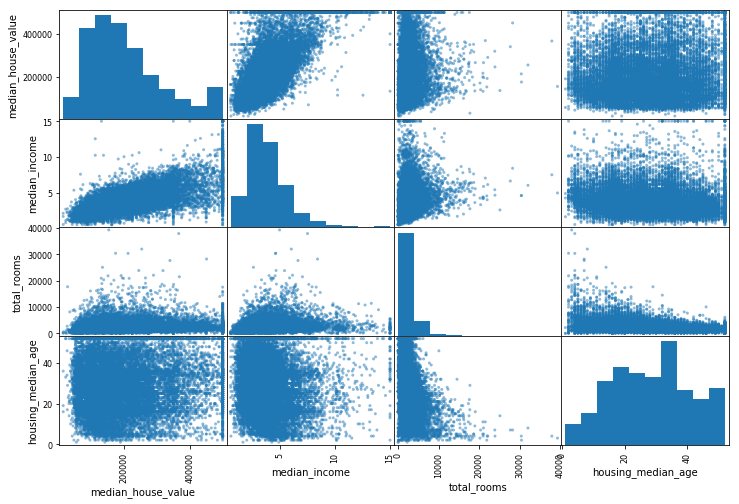

In [24]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing_data[attributes],figsize=(12,8))
plt.show()

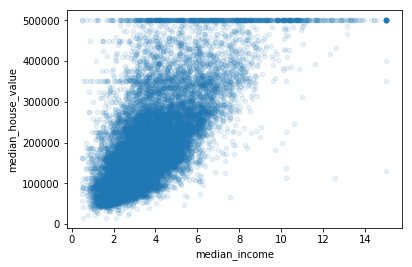

In [25]:
housing_data.plot(kind = 'scatter', x='median_income',y='median_house_value',alpha=0.1)
plt.show()

Let's try to remove districts that are contributing to those horizontal lines since that is likely a quirk of how the data were preprocessed in the first place.

In [26]:
housing_data.groupby(by='median_house_value').agg('count').sort_values(by='longitude',ascending=False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
median_house_value,,,,,,,,,,,,,
500001.0,786,786,786,786,781,786,786,786,786,786,786,786,786
137500.0,102,102,102,102,99,102,102,102,102,102,102,102,102
162500.0,91,91,91,91,90,91,91,91,91,91,91,91,91
112500.0,80,80,80,80,80,80,80,80,80,80,80,80,80
187500.0,76,76,76,76,75,76,76,76,76,76,76,76,76
225000.0,70,70,70,70,70,70,70,70,70,70,70,70,70
350000.0,65,65,65,65,65,65,65,65,65,65,65,65,65
87500.0,59,59,59,59,58,59,59,59,59,59,59,59,59
150000.0,58,58,58,58,58,58,58,58,58,58,58,58,58


## First cleaning step
We'll try removing districts that contribute to rows of this group by dataframe with count higher than say 40 to start

In [27]:
grouped_housing = housing_data.groupby(by='median_house_value').agg('count').sort_values(by='longitude',ascending=False)
bad_values = np.asarray(grouped_housing.loc[grouped_housing['longitude'] > 40].index)
housing_cleaned_v1 = housing_data[lambda x : [x not in bad_values for x in housing_data['median_house_value'].values]]
housing_cleaned_v1.reset_index()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,1,0,0,0,0
1,18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,1,0,0,0,0
2,14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,0,0,0,0,1
3,3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,0,1,0,0,0
4,3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,1,0,0,0,0
5,19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,127900.0,0,1,0,0,0
6,13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,140200.0,0,1,0,0,0
7,4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,95000.0,1,0,0,0,0
8,16365,-121.31,38.02,24.0,4157.0,951.0,2734.0,879.0,2.7981,92100.0,0,1,0,0,0
9,19684,-121.62,39.14,41.0,2183.0,559.0,1202.0,506.0,1.6902,61500.0,0,1,0,0,0


We have now removed bad districts, let's see if we did good enough

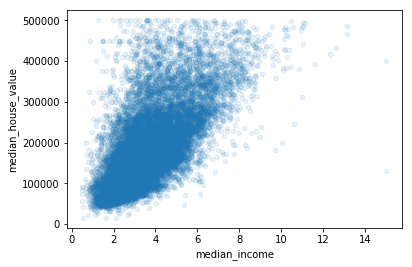

In [28]:
housing_cleaned_v1.plot(kind = 'scatter', x='median_income',y='median_house_value',alpha=0.1)
plt.show()

There is still some traces, but it's probably good enough at this point

In [29]:
corr_matrix = housing_data.corr()
print(corr_matrix['median_house_value'])
corr_matrix = housing_cleaned_v1.corr()
corr_matrix['median_house_value']

longitude            -0.047432
latitude             -0.142724
housing_median_age    0.114110
total_rooms           0.135097
total_bedrooms        0.047689
population           -0.026920
households            0.064506
median_income         0.687160
median_house_value    1.000000
<1H OCEAN             0.259521
INLAND               -0.482886
ISLAND                0.013709
NEAR BAY              0.158733
NEAR OCEAN            0.137378
Name: median_house_value, dtype: float64


longitude            -0.041954
latitude             -0.155281
housing_median_age    0.073693
total_rooms           0.139269
total_bedrooms        0.068585
population            0.004109
households            0.089673
median_income         0.654148
median_house_value    1.000000
<1H OCEAN             0.292000
INLAND               -0.505722
ISLAND                0.018466
NEAR BAY              0.153696
NEAR OCEAN            0.140204
Name: median_house_value, dtype: float64

It's interesting to note that the correlation strength went down a bit with cleaning, but that's ok because we don't want to learn quirks of the data that aren't real.

## Additional features
- Let's take a minute just to consider some attribute combinations to see if we come up with additional useful features.

In [30]:
housing_cleaned_v1 = housing_cleaned_v1.copy()
housing_cleaned_v1.loc[:,'rooms_per_household'] = housing_cleaned_v1.loc[:,'total_rooms'].values/housing_cleaned_v1.loc[:,'households'].values
housing_cleaned_v1.loc[:,'bedrooms_per_room'] = housing_cleaned_v1.loc[:,'total_bedrooms']/housing_cleaned_v1.loc[:,'total_rooms']
housing_cleaned_v1.loc[:,'population_per_household'] = housing_cleaned_v1.loc[:,'population']/housing_cleaned_v1.loc[:,'households']
corr_matrix = housing_cleaned_v1.corr()
corr_matrix['median_house_value']

longitude                  -0.041954
latitude                   -0.155281
housing_median_age          0.073693
total_rooms                 0.139269
total_bedrooms              0.068585
population                  0.004109
households                  0.089673
median_income               0.654148
median_house_value          1.000000
<1H OCEAN                   0.292000
INLAND                     -0.505722
ISLAND                      0.018466
NEAR BAY                    0.153696
NEAR OCEAN                  0.140204
rooms_per_household         0.137633
bedrooms_per_room          -0.243456
population_per_household   -0.188036
Name: median_house_value, dtype: float64

In [31]:
housing_cleaned_v1.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,1,0,0,0,0,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,1,0,0,0,0,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,0,0,0,0,1,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,0,1,0,0,0,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,1,0,0,0,0,4.505810,0.231341,3.047847


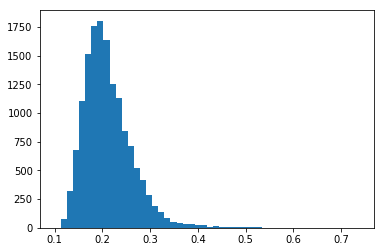

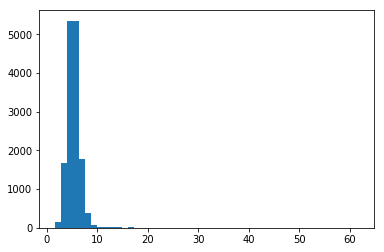

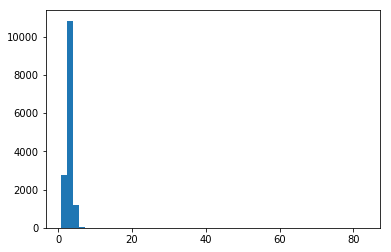

In [32]:
plt.hist(housing_cleaned_v1['bedrooms_per_room'].dropna().values,bins=50)
plt.show()
plt.hist(housing_cleaned_v1['rooms_per_household'].dropna().values,bins=50)
plt.show()
plt.hist(housing_cleaned_v1['population_per_household'].dropna().values,bins=50)
plt.show()

# Data cleaning and preprocessing

In [105]:
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    
    def __init__(self, add_attr_dict = {'bedrooms_per_room':True,
                                        'rooms_per_household':True,
                                        'population_per_household':True}):
        
        self.add_bedrooms_per_room = add_attr_dict['bedrooms_per_room']
        self.add_rooms_per_household = add_attr_dict['rooms_per_household']
        self.add_population_per_household = add_attr_dict['population_per_household']
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X, y = None):
        
        if self.add_bedrooms_per_room:
            
            bedrooms_per_room = X.loc[:,'total_bedrooms'] / X.loc[:, 'total_rooms']
            
            X.loc[:,'bedrooms_per_room'] = bedrooms_per_room
            
        if self.add_rooms_per_household:
            
            rooms_per_household = X.loc[:, 'total_rooms'] / X.loc[:, 'households']
            
            X.loc[:,'rooms_per_household'] = rooms_per_household
            
        if self.add_population_per_household:
            
            population_per_household = X.loc[:,'population'] / X.loc[:, 'households']
            
            X.loc[:,'population_per_household'] = population_per_household
            
            
        return X

attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing_cleaned_v1.copy())

In [34]:
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,1,0,0,0,0,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,1,0,0,0,0,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,0,0,0,0,1,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,0,1,0,0,0,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,1,0,0,0,0,4.505810,0.231341,3.047847


In [35]:
imputer = Imputer(strategy = 'median')

housing_num = housing_extra_attribs.drop(['<1H OCEAN','INLAND','ISLAND','NEAR BAY','NEAR OCEAN'], axis=1)

imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [36]:
imputer.statistics_

array([-1.18530000e+02,  3.42800000e+01,  2.80000000e+01,  2.15000000e+03,
        4.39000000e+02,  1.19600000e+03,  4.15000000e+02,  3.51790000e+00,
        1.75500000e+05,  5.22666298e+00,  2.02920830e-01,  2.83906333e+00])

In [37]:
housing_num.median().values

array([-1.18530000e+02,  3.42800000e+01,  2.80000000e+01,  2.15000000e+03,
        4.39000000e+02,  1.19600000e+03,  4.15000000e+02,  3.51790000e+00,
        1.75500000e+05,  5.22666298e+00,  2.02920830e-01,  2.83906333e+00])

In [38]:
X = imputer.transform(housing_num)

In [39]:
housing_tr = pd.DataFrame(X,columns=housing_num.columns)

## Data transformation pipeline
- Let's make a pipeline so that we don't have to do all of those steps individually, and we can in principle tune hyper parameters later in a grid search cross validation step.

In [106]:
# Transformer to select a subset of attributes (will be used to grab numerical/categorical separately)
class DataFrameSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self, attributes):
        
        self.attributes = attributes
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):
        
        return X[self.attributes]

    
# Remove districts that have too many of the same median house value since these are then strange bands in the data seend
# include the cutoff as a 
class RemoveOddDistricts(BaseEstimator, TransformerMixin):
    
    def __init__(self, cutoff = 40):
        
        self.cutoff = cutoff
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):
        
        grouped_X = X.groupby(by='median_house_value').agg('count')
        bad_values = np.asarray(grouped_X.loc[grouped_X['longitude'] > self.cutoff].index)
        X_cleaned = X[lambda x : [x not in bad_values for x in X['median_house_value'].values]]
        X_cleaned.reset_index()
        
        return X_cleaned
    
# A transformer which drops any unlabeled data
class DropUnlabeled(BaseEstimator,TransformerMixin):
    
    def __init__(self, label):
        
        self.target = label
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):
        
        return X.dropna(subset=[self.target])
    
    
# A transformer which drops any unlabeled data
class LogTransformer(BaseEstimator,TransformerMixin):
    
    def __init__(self, all_attr, log_transform_attr,log_transform=True):
        
        self.all_attr = all_attr
        self.log_transform_attr = log_transform_attr
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):
        
        X = pd.DataFrame(X,columns=self.all_attr)
        if log_transform:
            
            for attr in self.log_transform_attr:
                
                if attr in all_attr:
            
                    X.loc[:,attr] = np.log(X.loc[:,attr] + np.ones(len(X.loc[:,attr])))
        
        return X.values

        

In [107]:
# Test removal transformer
remove = RemoveOddDistricts(30)
cleaned = remove.transform(housing_data)

In [108]:
cleaned.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,14807.000000,14807.000000,14807.000000,14807.000000,14663.000000,14807.000000,14807.000000,14807.000000,14807.000000,14807.000000,14807.000000,14807.000000,14807.000000,14807.000000
mean,-119.566445,35.659331,28.313230,2672.811508,545.223351,1460.166813,507.242588,3.731348,193643.600797,0.437563,0.334369,0.000135,0.106098,0.121834
std,2.004436,2.152574,12.424276,2159.352101,417.112153,1129.344501,379.194105,1.562491,98971.842341,0.496103,0.471785,0.011622,0.307974,0.327105
min,-124.350000,32.550000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.770000,33.930000,18.000000,1477.500000,302.000000,815.000000,287.000000,2.575000,116700.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.530000,34.280000,28.000000,2155.000000,440.000000,1197.000000,415.000000,3.520800,174300.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-117.990000,37.730000,37.000000,3169.000000,652.000000,1757.000000,609.000000,4.643950,249550.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500000.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
# Test label nan removal
test_df = pd.DataFrame({'median_house_value':[np.nan,1,3],'other':[1,np.nan,3]})

drop = DropUnlabeled('median_house_value')
drop.transform(test_df)

,median_house_value,other
1,1.0,NaN
2,3.0,3.0


In [111]:
target_label = ['median_house_value']

num_attr = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
            'population','households', 'median_income']

add_attr_names = ['bedrooms_per_room','rooms_per_household','population_per_household']

all_attr = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
            'population','households', 'median_income']

log_transform = True

for i in range(0,3):
    
    if add_attr[i]:
            
        all_attr.append(add_attr_names[i])
        
log_attr = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

cat_attr = ['<1H OCEAN','INLAND','ISLAND','NEAR BAY','NEAR OCEAN']

target_pipeline = Pipeline([('DropUnlabeled', DropUnlabeled('median_house_value')), ('DropOddDist', RemoveOddDistricts()),
                           ('GetTarget' ,DataFrameSelector(target_label)), ])

num_pipeline = Pipeline([('DropUnlabeled', DropUnlabeled('median_house_value')), ('DropOddDist', RemoveOddDistricts()),
                         ('GetNumAttr', DataFrameSelector(num_attr)), ('CombAttrAdd', CombinedAttributesAdder()),
                         ('Impute', Imputer(strategy='median')), ('Log Transform', LogTransformer(all_attr,log_attr,log_transform)), 
                         ('Scale', StandardScaler()), ])

cat_pipeline = Pipeline([('DropUnlabeled', DropUnlabeled('median_house_value')), ('DropOddDist', RemoveOddDistricts()),
                         ('GetCatAttr', DataFrameSelector(cat_attr)), ])

feature_pipeline = FeatureUnion(transformer_list = [('num_pipe',num_pipeline), ('cat_pipt',cat_pipeline), ])

In [112]:
targets = target_pipeline.fit_transform(strat_train_set).values.reshape(-1,)

In [113]:
features = feature_pipeline.fit_transform(strat_train_set)

# Model prototyping
- Here we will just test a few models to see which the most viable are likely to be (no hyperparameter tuning yet)

In [114]:
lin_reg = LinearRegression()
lin_reg.fit(features,targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
some_data = strat_train_set.iloc[:5]

some_features = feature_pipeline.transform(some_data)

some_labels = target_pipeline.transform(some_data)

print('Predictions:\t', lin_reg.predict(some_features).flatten())

print('Labels:\t',list(some_labels.values.flatten()))

Predictions:	 [225499.9975683  300900.99225421 223513.88984791  31235.94076709
 187417.42535127]
Labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [116]:
predictions = lin_reg.predict(features)
lin_mse = mean_squared_error(targets,predictions)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE on training set:\t',lin_rmse)

Linear Regression RMSE on training set:	 59057.9499196663


In [128]:
ridge_reg = Ridge()
ridge_reg.fit(features,targets)
predictions = ridge_reg.predict(features)
ridge_mse = mean_squared_error(targets,predictions)
ridge_rmse = np.sqrt(ridge_mse)
print('Ridge Regression RMSE on training set:\t',ridge_rmse)

Ridge Regression RMSE on training set:	 59059.435873254726


In [117]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(features,targets)
predictions = tree_reg.predict(features)
tree_mse = mean_squared_error(targets,predictions)
tree_rmse = np.sqrt(tree_mse)
print('Decision Tree Regression RMSE on training set:\t',tree_rmse)

Decision Tree Regression RMSE on training set:	 0.0


### WHOOPS WE OVERFIT
- Let's verify with cross validation

In [118]:
lin_scores = cross_val_score(lin_reg, features, targets, scoring = 'neg_mean_squared_error', cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
tree_scores = cross_val_score(tree_reg, features, targets, scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):

    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Std:', scores.std())
    
display_scores(lin_rmse_scores)    
display_scores(tree_rmse_scores)

Scores: [67110.12930912 58255.00510711 59670.19068669 61357.36897962
 59807.20860516 60967.71065531 57585.25910438 57768.96195767
 60760.80262301 57733.12645575]
Mean: 60101.57634838178
Std: 2700.8640510692117
Scores: [56581.11736178 62673.91994899 65242.21580107 62427.91243647
 64560.29365487 63235.95405583 62840.22681518 61345.30406352
 66550.13572124 62214.90806026]
Mean: 62767.1987919203
Std: 2541.5507881748686


So there we have it, the decision tree performs more poorly than linear regression as indicated by higher rmse from cross validation. This type of behavior (performing well on training set but not on validation set) is indicative of over fitting

In [119]:
forest_reg = RandomForestRegressor()
forest_reg.fit(features,targets)
forest_scores = cross_val_score(forest_reg, features, y=targets, scoring = 'neg_mean_squared_error', cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [45178.57874408 45472.56642953 47732.16017346 47510.68322076
 46503.45036711 47112.47081953 44859.65332238 45413.72381582
 48513.4326891  46315.61048866]
Mean: 46461.233007044124
Std: 1168.7694645216122


The random forest regressor does the best so far. Let's do one more (a support vector machine)

In [56]:
svm = SVR()
svm.fit(features,targets)
predictions = svm.predict(features)
svm_mse = mean_squared_error(targets,predictions)
svm_rmse = np.sqrt(svm_mse)
print('Support Vector Regression RMSE on training set:\t',svm_rmse)

Support Vector Regression RMSE on training set:	 100129.10499580455


In [57]:
svm = SVR()
svm.fit(features,targets)
svm_scores = cross_val_score(svm, features, y=targets, scoring = 'neg_mean_squared_error', cv = 10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [ 92853.90099553 101530.50797959  99062.85000473 100679.73904149
 102279.09623632 102778.13436624  99966.09091529 101147.35183177
 101129.3029741  100069.00064644]
Mean: 100149.59749915056
Std: 2646.42493522161


So SVM doesn't do as well by default. But here it is possible we are under fitting. There are a number of hyperparameters available to the SVM regressor which I want to play with so we will include this model in the set of models we perform grid search CV on. Before we move on, let's save these fitted models in case we would like to come back to them. (In general we would also like to save cross-validation scores and possibly predictions if the model takes awhile to run, but with GridSearchCV we should have CV scores with the model.)

In [129]:
joblib.dump(lin_reg, 'default_linear_regressor.pkl')
joblib.dump(ridge_reg, 'default_ridge_regressor.pkl')
joblib.dump(tree_reg, 'default_decision_tree_regressor.pkl')
joblib.dump(forest_reg, 'default_random_forest_regressor.pkl')
joblib.dump(svm, 'default_support_vector_regressor.pkl')

['default_support_vector_regressor.pkl']

In [59]:
# Let's check that when we load a model we have access to it's parameters
my_model_loaded = joblib.load('default_random_forest_regressor.pkl')

In [60]:
my_model_loaded.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

In [61]:
my_model_loaded.feature_importances_

array([7.75478516e-02, 6.99048501e-02, 4.30129753e-02, 1.33628497e-02,
       1.16180553e-02, 1.19800665e-02, 1.03814057e-02, 4.24957487e-01,
       2.43888832e-02, 2.64263023e-02, 1.21418703e-01, 2.23871683e-03,
       1.59530945e-01, 9.10057502e-05, 6.22164436e-04, 2.51773900e-03])

# Model Fine Tuning
- We have a few candidate models: 
    - Ridge Regression (has a few more hyper parameters than regular linear regression)
    - Random Forest Regression
    - Support Vector Regression
- Let's fine tune them some using gridsearch cv to tune hyper parameters.

In [150]:
linear_regressor_grid = GridSearchCV(Ridge(),param_grid = {'alpha':[0.1,1,10]},refit=True,return_train_score=True
                                    ,scoring='neg_mean_squared_error')                              

In [151]:
linear_regressor_grid.fit(features,targets)
display_scores(np.sqrt(-linear_regressor_grid.cv_results_['mean_test_score']))

Scores: [60554.29962734 60448.77762128 59765.89923116]
Mean: 60256.325493261415
Std: 349.44924510470514


In [158]:
rf_regressor_grid = GridSearchCV(RandomForestRegressor(),param_grid = {'n_estimators':[10,100,250],
                                                                      'max_depth':[10,12,14]},refit=True,return_train_score=True
                                    ,scoring='neg_mean_squared_error')                              

In [160]:
rf_regressor_grid.fit(features,targets)
display_scores(np.sqrt(-rf_regressor_grid.cv_results_['mean_test_score']))

Scores: [48755.87556059 47423.84679235 47359.45520954 48220.78666329
 46244.63222063 46229.17370379 47718.79399621 45770.17010652
 45639.29761173]
Mean: 47040.225762738875
Std: 1049.503651525092


In [161]:
rf_regressor_grid.best_params_

{'max_depth': 14, 'n_estimators': 250}